# Prototype analysis model

Notebook to extract prototypes from each classes. 3 types of prototypes are considered:
- Top class prototypes: trajectories that represent at best a class. These are extracted by selecting trajectories
 for which the model has highest confidence in classification while being correct.
- Worst class prototypes: trajectories that were mistaken for another class. with largest confidence These are extracted
 by selecting trajectories for which the model has highest confidence in classification while being wrong.
- Least correlated prototypes: trajectories that represent the diversity in a class. These are extracted by selecting
trajectories where the model confidence wsa highest than a minimal threshold while being correct. In addition, the set
of trajectories is grown with a greedy algorithm that selects sequentially trajectories. The algorithm selects the next 
trajectory whose representation in the output layer (right before classification) is as least correlated to the rest of 
the set as possible.

## Import libraries

In [22]:
import results_model
import torch
from torch.utils.data import DataLoader
from class_dataset import myDataset, RandomCrop, Subtract, ToTensor
from torchvision import transforms
from load_data import DataProcesser
import seaborn as sns
import matplotlib as plt
import pandas as pd
import os
import numpy as np
import plotly.express as px

## Import model, data

In [2]:
#data_file = 'data/ErkAkt_6GF_len240_repl2_trim100.zip'
data_file = '/home/marc/Dropbox/Work/TSclass_GF/forPaper/data_figures/ErkAkt_forPaper_200trimmed.zip'
model_file = '/home/marc/Dropbox/Work/TSclass_GF/forPaper/models/ERK_AKT/2019-07-04-11:21:58_ErkAkt_6GF_len240_repl2_trim100.pytorch'
meas_var = ['ERK', 'AKT']
batch_size = 800 # Set as high as your memory allow to speed up
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torch.load(model_file)
model.eval()
model.double()
model.batch_size = 1
model = model.to(device)

data = DataProcesser(data_file)
data.subset(sel_groups=meas_var, start_time=0, end_time=600)
data.get_stats()
#data.process(method='center_train', independent_groups=True)
data.split_sets()
classes = tuple(data.classes.iloc[:,1])
dict_classes = data.classes['class']

data_test = myDataset(dataset=data.validation_set, transform=transforms.Compose([
    RandomCrop(output_size=model.length, ignore_na_tails=True),
    Subtract([data.stats['mu']['ERK']['train'], data.stats['mu']['AKT']['train']]),
    ToTensor()]))
test_loader = DataLoader(dataset=data_test,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=4)

/home/marc/Dropbox/Work/TSclass_GF/load_data.py:116: UserWarning:

ID list is different between dataset and id_set.

/home/marc/Dropbox/Work/TSclass_GF/load_data.py:121: UserWarning:

At least some column names of dataset are ill-formatted. Should follow "Group_Time" format. List of ill-formatted: ['C0', 'C0']

/home/marc/Dropbox/Work/TSclass_GF/load_data.py:425: UserWarning:

Data were not processed.



Plot some trajectories to check that the data loading and processing is properly done.

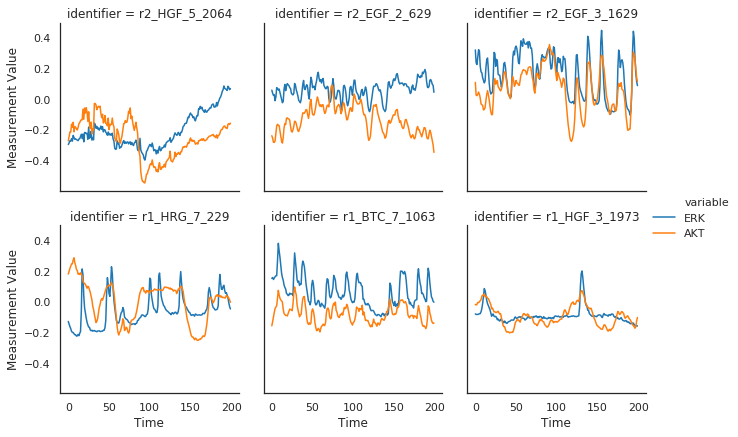

In [3]:
n_smpl = 6
indx_smpl = np.random.randint(0, len(data_test), n_smpl)
length = model.length

col_ids = []
col_lab = []
col_mes = []
# Long format for seaborn grid, for loop to avoid multiple indexing
# This would triggers preprocessing multiple times and add randomness
for i in indx_smpl:
    smpl = data_test[i]
    col_ids.append(smpl['identifier'])
    col_lab.append(smpl['label'].item())
    col_mes.append(smpl['series'].numpy().transpose())
col_ids = pd.Series(np.hstack(np.repeat(col_ids, length)))
col_lab = pd.Series(np.hstack(np.repeat(col_lab, length)))
col_mes = pd.DataFrame(np.vstack(col_mes), columns=meas_var)
col_tim = pd.Series(np.tile(np.arange(0, length), n_smpl))

df_smpl = pd.concat([col_ids, col_lab, col_tim, col_mes], axis=1)
df_smpl.rename(columns={0: 'identifier', 1: 'label', 2:'time'}, inplace=True)
df_smpl = df_smpl.melt(id_vars=['identifier', 'label', 'time'], value_vars=meas_var)

sns.set_style('white')
sns.set_context('notebook')
grid = sns.FacetGrid(data=df_smpl, col='identifier', col_wrap=3, sharex=True)
grid.map_dataframe(sns.lineplot, x='time', y='value', hue='variable')
grid.set(xlabel='Time', ylabel='Measurement Value')
grid.add_legend()

## Confusion matrix

In [4]:
accuracy = results_model.acc_per_class(model, test_loader, device, dict_classes)
conft = results_model.confusion_matrix(model, test_loader, device, dict_classes)
conft['Accuracy'] = accuracy
print(conft)

100%|██████████| 3/3 [00:02<00:00,  1.12it/s]
/home/marc/Dropbox/Work/TSclass_GF/results_model.py:55: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

Prediction  BTC  CTR  EGF  EPR  HGF  HRG  IGF  Accuracy
Class                                                  
BTC         165    6   48   10    4    3    2  0.693277
CTR          18  188    3    3   92   14   27  0.544928
EGF          57    6  176   16    1    3    0  0.679537
EPR           9    3   16  180    0    1    0  0.861244
HGF          15  144    7    2  173   14   34  0.444730
HRG           0    8    2    1   18  312   45  0.808290
IGF           0   18    0    1   11   16  362  0.887255


## Prototypes extraction

In [5]:
ntop = 5
nworst = 5
nuncor = 5

### Top trajectories per class

In [6]:
tops = results_model.top_confidence_perclass(model, test_loader, n=ntop, labels_classes=dict_classes)

100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


AttributeError: module 'matplotlib' has no attribute 'gcf'

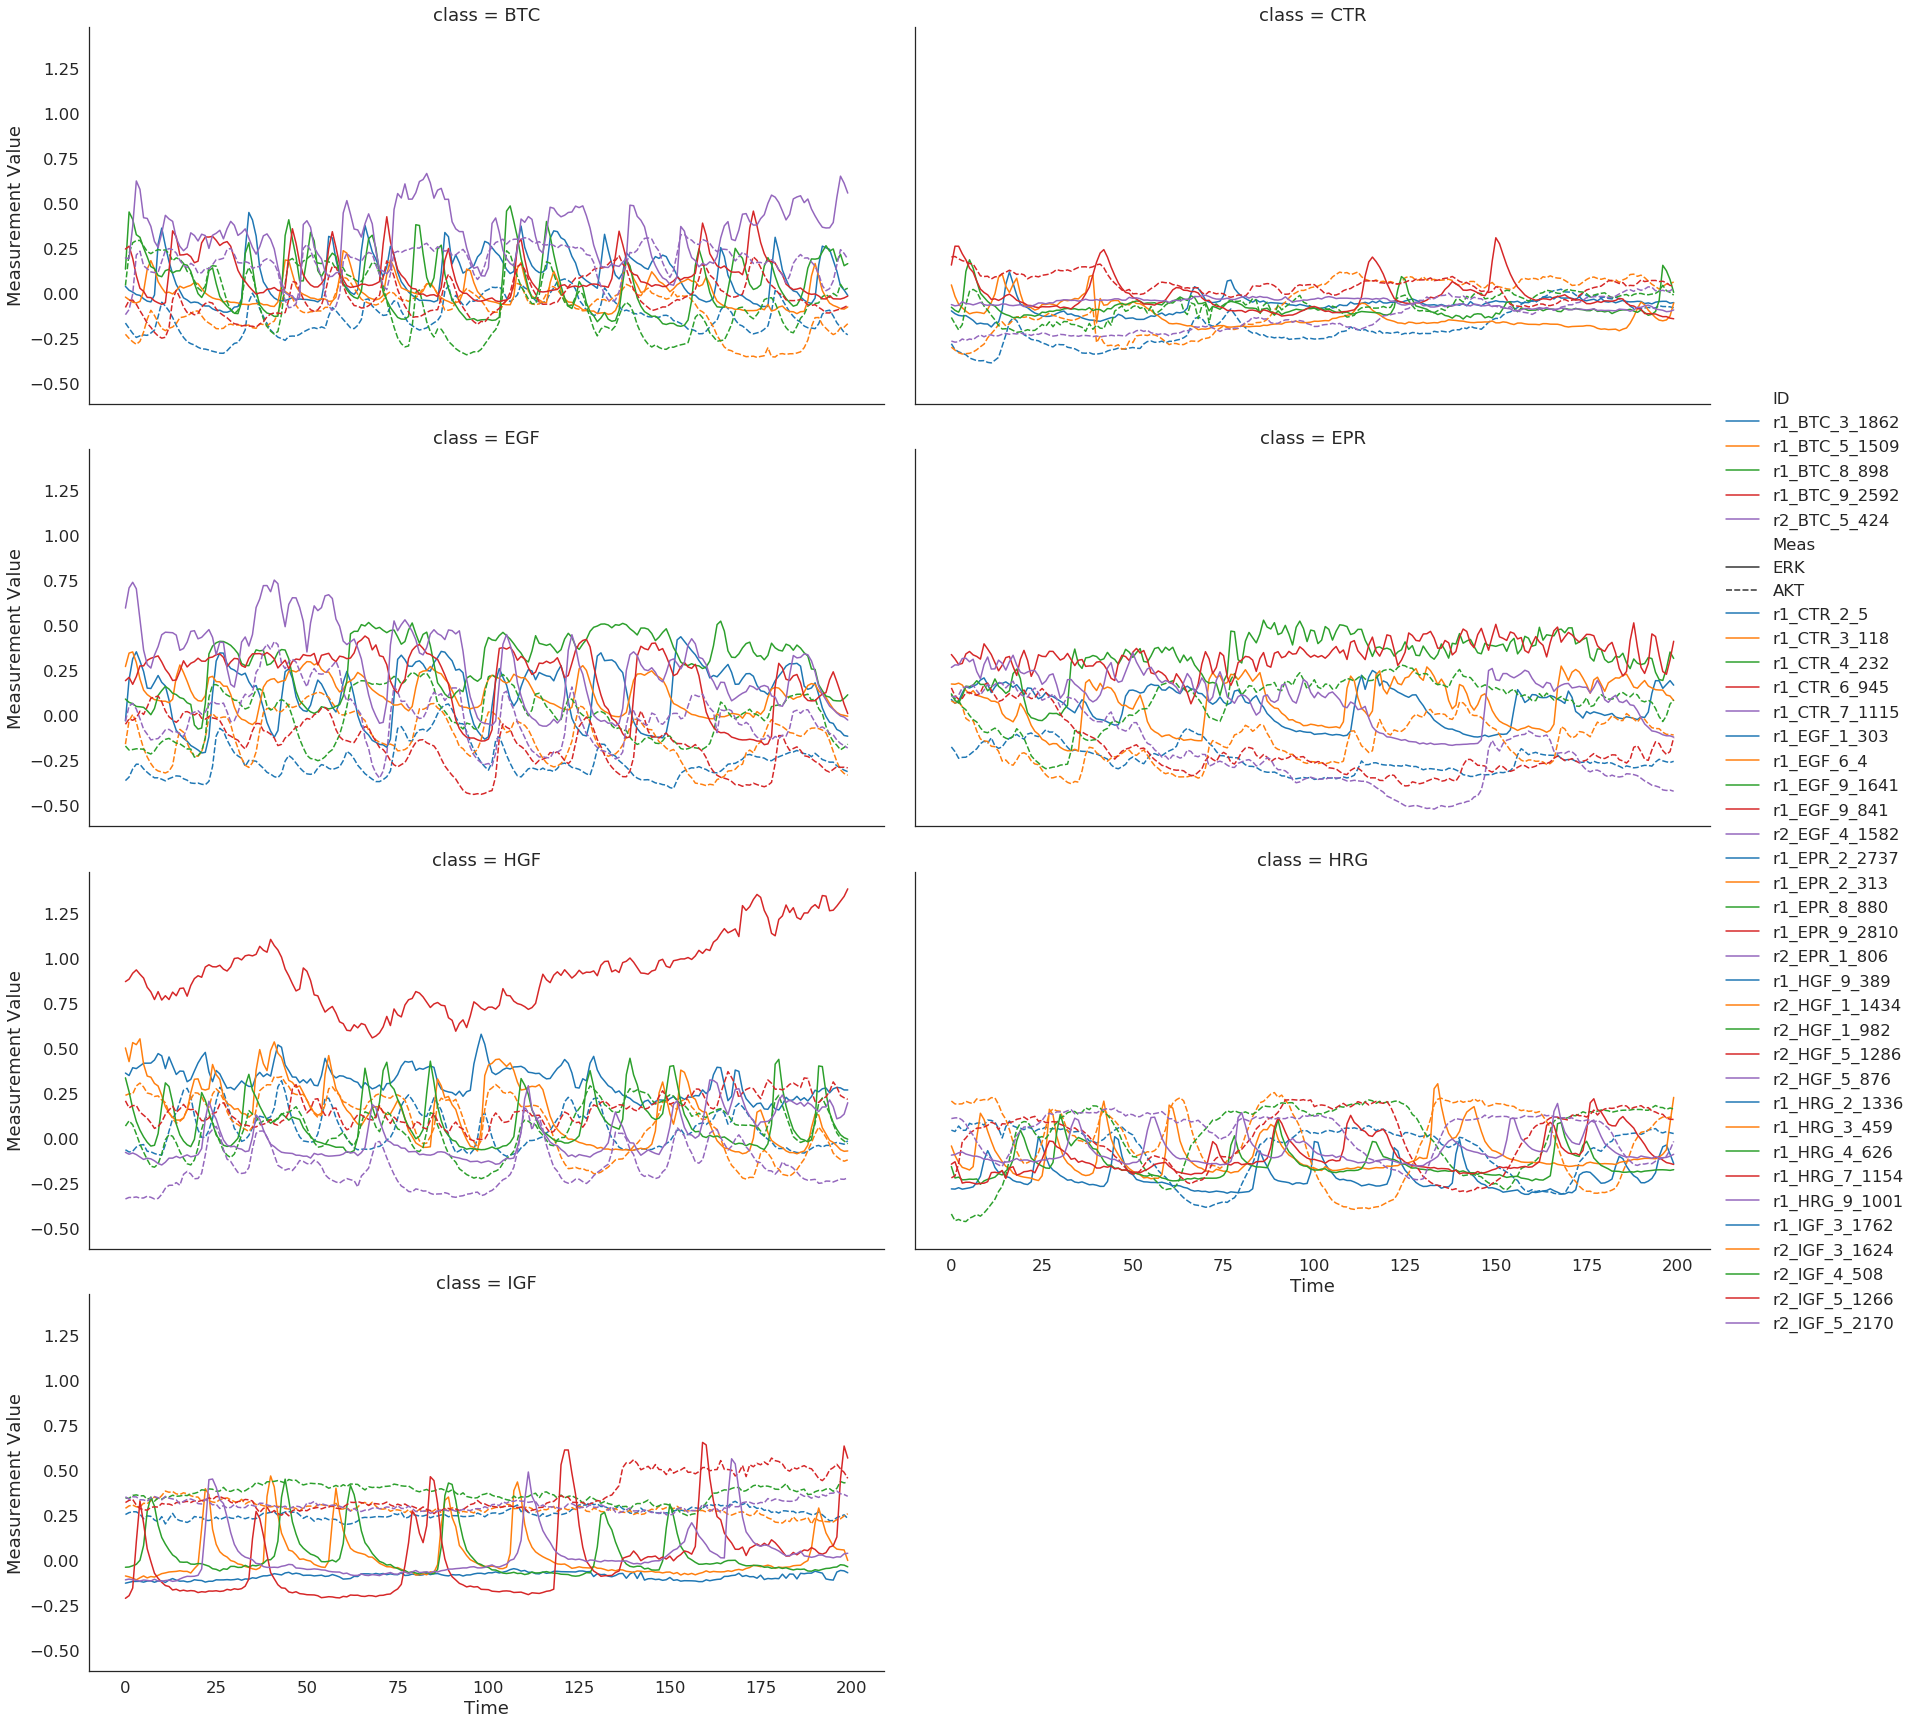

In [7]:
subset = data.validation_set.loc[data.validation_set['ID'].isin(tops['ID'])]
subset = subset.melt(id_vars=['ID', 'class'])
subset[['Meas','Time']]=subset['variable'].str.extract(r'^(?P<Meas>[A-Za-z]+)_(?P<Time>\d+)$')
subset['Time'] = subset['Time'].astype('int')
subset = pd.merge(subset, data.classes, left_on='class', right_on='class_ID')
subset.drop(columns='class_x', inplace=True)
subset.rename({'class_y': 'class'}, axis=1, inplace=True)
sns.set_style("white")
sns.set_context('notebook', font_scale=1.5)
grid = sns.FacetGrid(data=subset, col="class", col_wrap=2, sharex=True, height=6, aspect=2)
grid.map_dataframe(sns.lineplot, x="Time", y="value", hue="ID", style='Meas')
grid.set(xlabel='Time', ylabel='Measurement Value')
grid.add_legend()

In [ ]:
grid.savefig('output/' + '_'.join(meas_var) + '/tops_' + os.path.basename(model_file).rstrip('.pytorch') + '.pdf')

Interactive plot:

In [20]:
#selected_class=pd.unique(subset['class'])
selected_class=['HRG', 'BTC', 'CTR']
px.line(subset.loc[subset['class'].isin(selected_class)], x='Time', y='value', color='ID',
        line_group='Meas', line_dash='Meas', facet_col='class', facet_col_wrap=2)

### Worst trajectory per class

In [23]:
worsts = results_model.worst_classification_perclass(model, test_loader, n=nworst, labels_classes=dict_classes)

100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


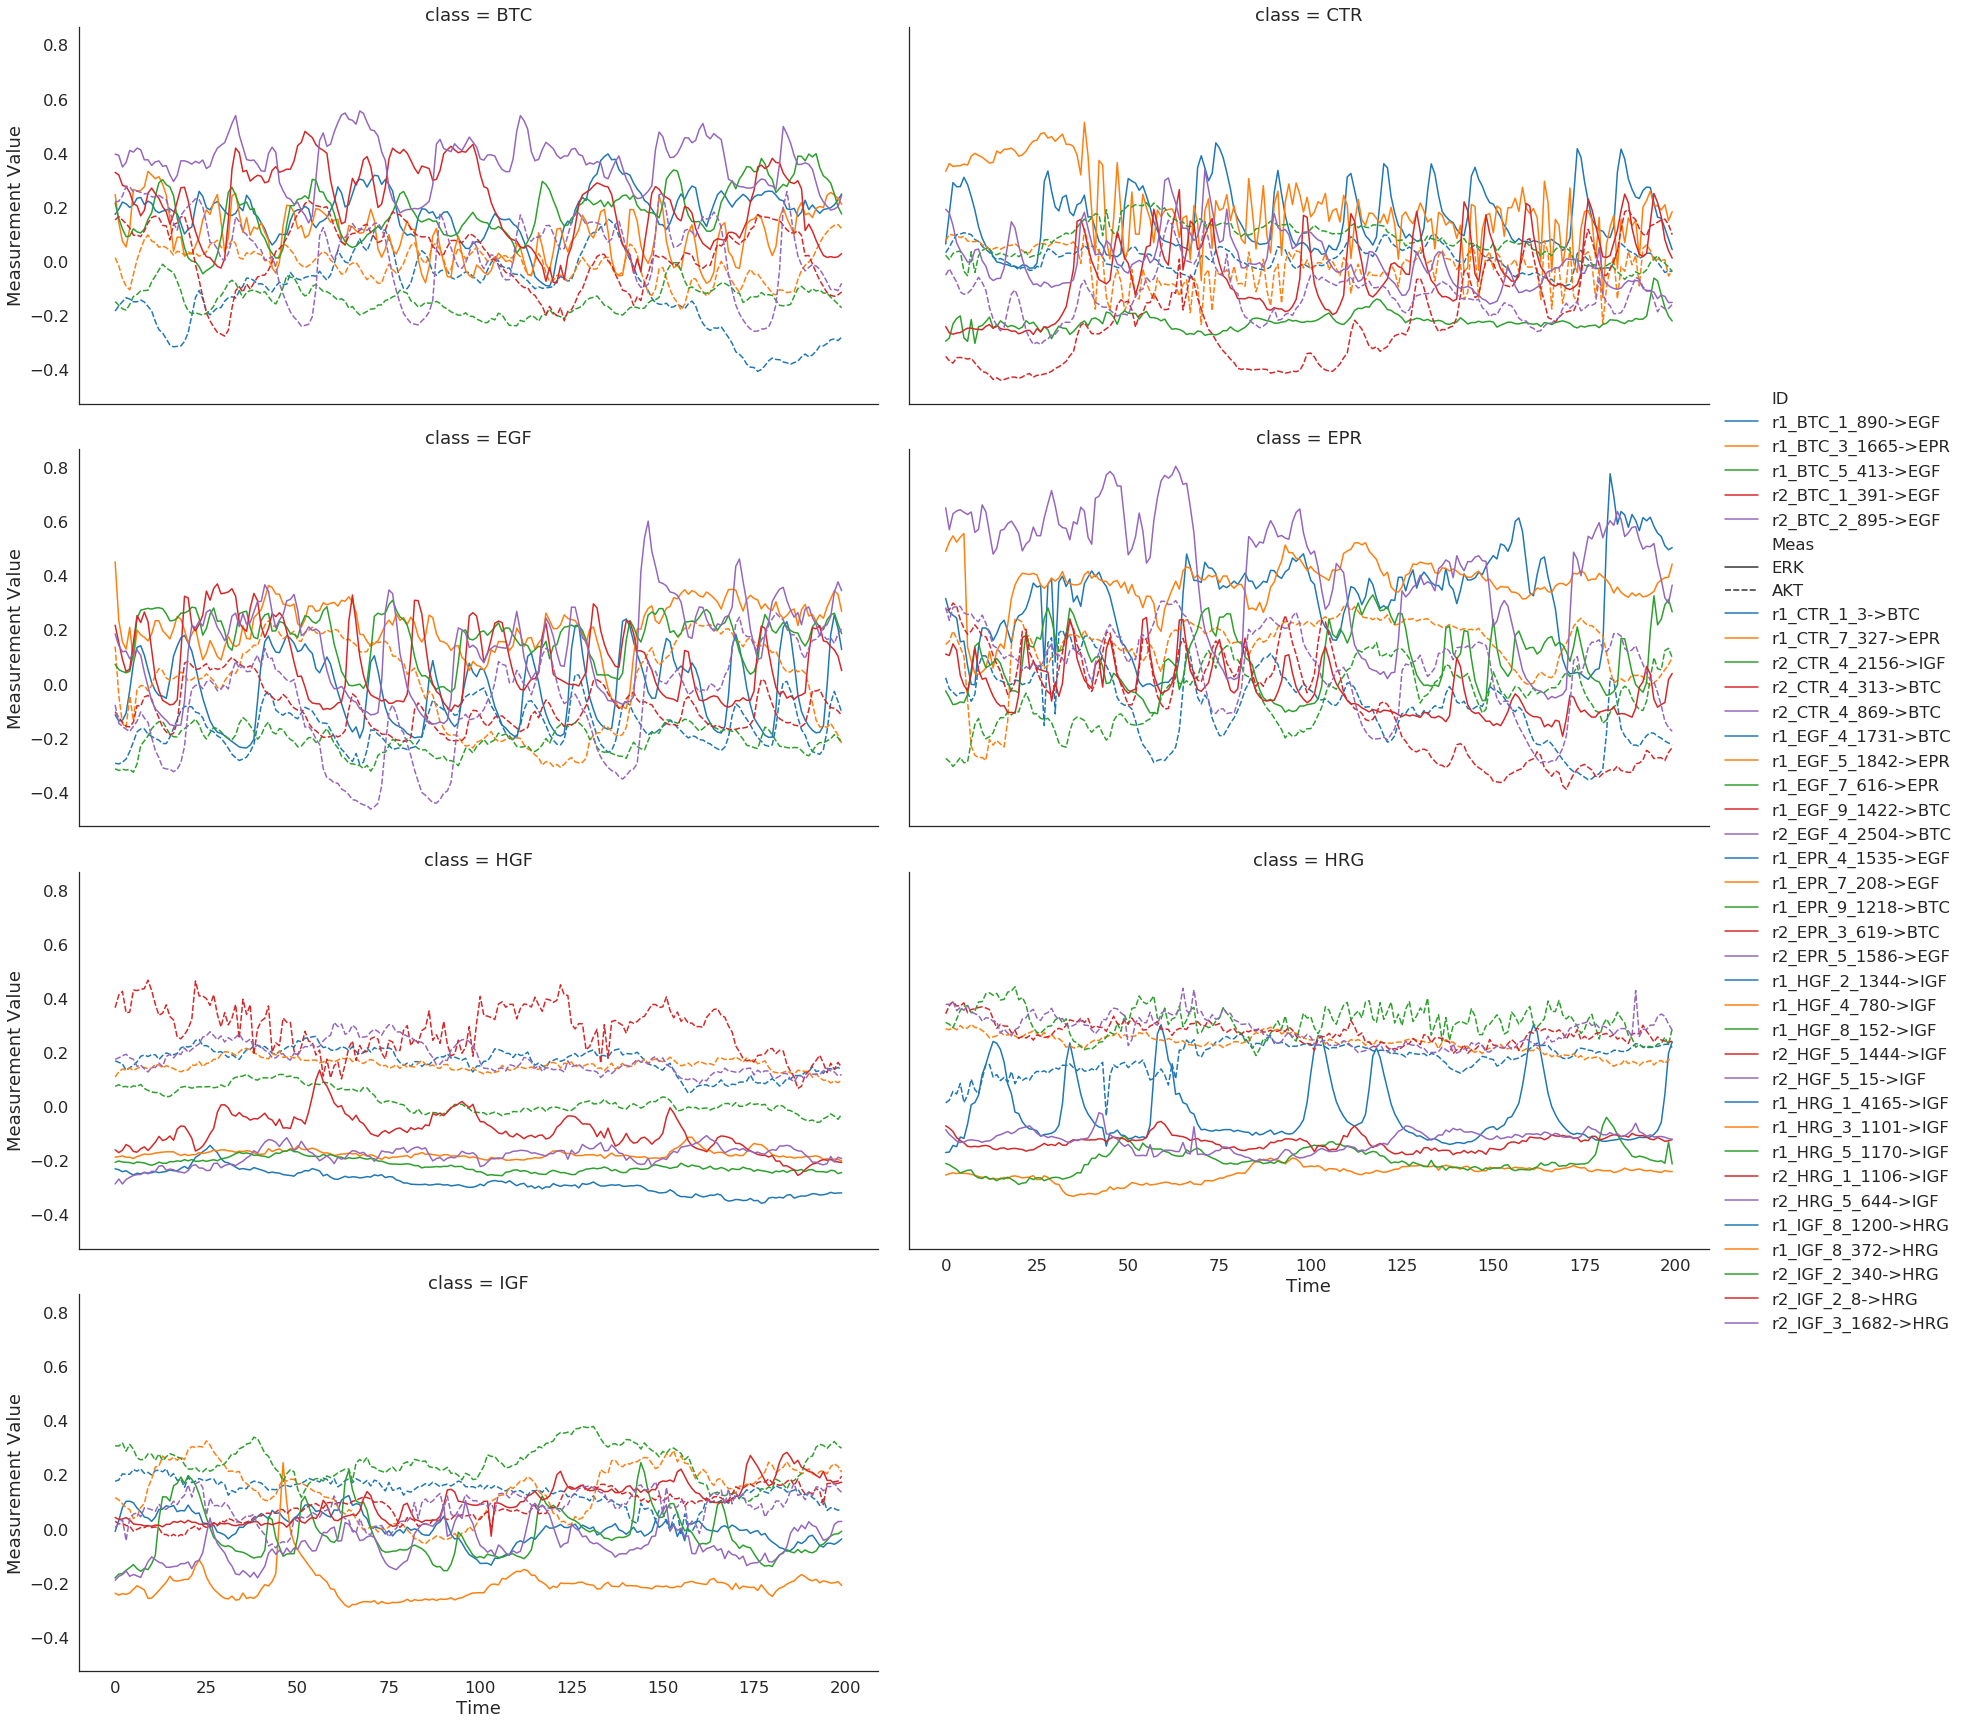

In [24]:
subset = data.validation_set.loc[data.validation_set['ID'].isin(worsts['ID'])]
subset = pd.merge(subset, worsts[['ID', 'Prediction']], on='ID')
subset = subset.melt(id_vars=['ID', 'class', 'Prediction'])
subset[['Meas','Time']]=subset['variable'].str.extract(r'^(?P<Meas>[A-Za-z]+)_(?P<Time>\d+)$')
subset['Time'] = subset['Time'].astype('int')
subset = pd.merge(subset, data.classes, left_on='class', right_on='class_ID')
subset.drop(columns='class_x', inplace=True)
subset.rename({'class_y': 'class'}, axis=1, inplace=True)
subset['ID'] = subset['ID'] + '->' + subset['Prediction']
sns.set_style("white")
sns.set_context('notebook', font_scale=1.5)
grid = sns.FacetGrid(data=subset, col="class", col_wrap=2, sharex=True, height=6, aspect=2)
grid.map_dataframe(sns.lineplot, x="Time", y="value", hue="ID", style='Meas')
grid.set(xlabel='Time', ylabel='Measurement Value')
grid.add_legend()

In [ ]:
grid.savefig('output/' + '_'.join(meas_var) + '/worsts_' + os.path.basename(model_file).rstrip('.pytorch') + '.pdf')

Interactive plot:

In [26]:
#selected_class=pd.unique(subset['class'])
selected_class=['BTC']
px.line(subset.loc[subset['class'].isin(selected_class)], x='Time', y='value', color='ID',
        line_group='Meas', line_dash='Meas', facet_col='class', facet_col_wrap=2)

### Least correlated set per class

In [27]:
uncorr = results_model.least_correlated_set(model, test_loader, n=nuncor, labels_classes=dict_classes)

100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


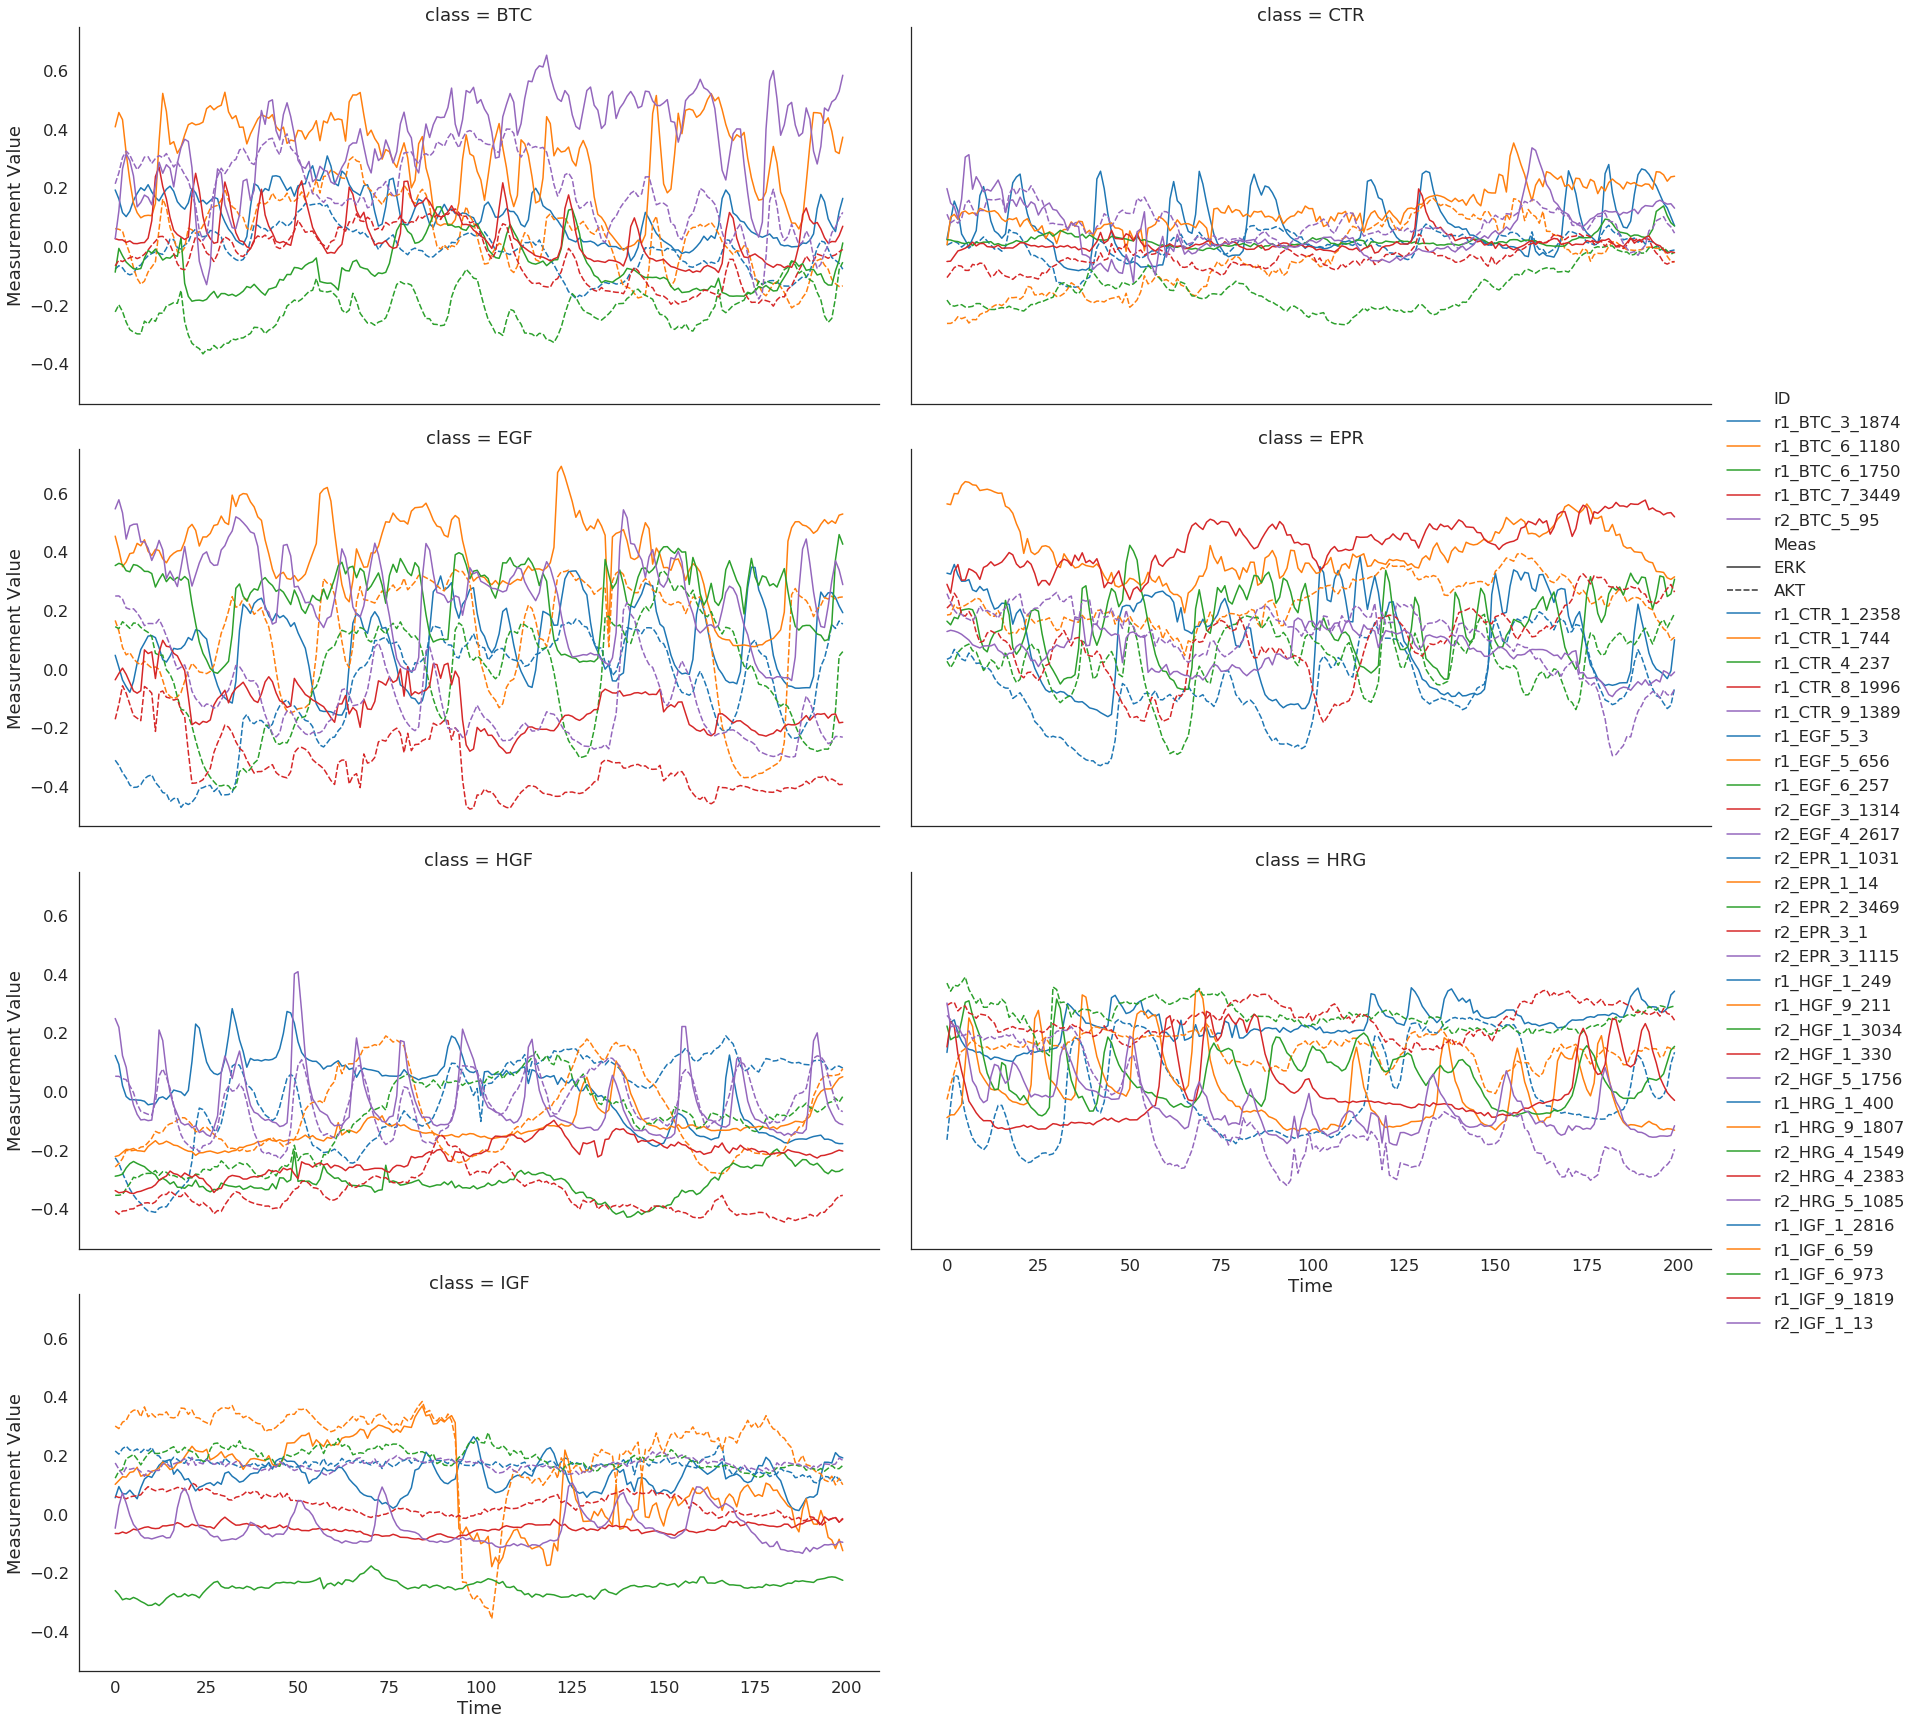

In [28]:
subset = data.validation_set.loc[data.validation_set['ID'].isin(uncorr['ID'])]
subset = subset.melt(id_vars=['ID', 'class'])
subset[['Meas','Time']]=subset['variable'].str.extract(r'^(?P<Meas>[A-Za-z]+)_(?P<Time>\d+)$')
subset['Time'] = subset['Time'].astype('int')
subset = pd.merge(subset, data.classes, left_on='class', right_on='class_ID')
subset.drop(columns='class_x', inplace=True)
subset.rename({'class_y': 'class'}, axis=1, inplace=True)
sns.set_style("white")
sns.set_context('notebook', font_scale=1.5)
grid = sns.FacetGrid(data=subset, col="class", col_wrap=2, sharex=True, height=6, aspect=2)
grid.map_dataframe(sns.lineplot, x="Time", y="value", hue="ID", style='Meas')
grid.set(xlabel='Time', ylabel='Measurement Value')
grid.add_legend()

In [ ]:
grid.savefig('output/' + '_'.join(meas_var) + '/uncorr_' + os.path.basename(model_file).rstrip('.pytorch') + '.pdf')

Interactive plot:

In [29]:
#selected_class=pd.unique(subset['class'])
selected_class=['BTC']
px.line(subset.loc[subset['class'].isin(selected_class)], x='Time', y='value', color='ID',
        line_group='Meas', line_dash='Meas', facet_col='class', facet_col_wrap=2)